In [1]:
!pip install salabim


In [1]:
import salabim as sim
import math

In [22]:


# Constants
up = 1
down = -1
still = 0

move_time = 2
dooropen_time = 2
doorclose_time = 2

enter_time = 2
exit_time = 1

capacity = 8

topfloor = 12  # 0: Ground floor, 1-12: Employee floors

elevatorcount = 2 

id = "morning" #persons created in the morning

def run_simulation(seed: int, trace=True, sim_duration=10*3600, warmup=3600) -> list:
    env = sim.Environment(random_seed=seed)

    class PersonGenerator(sim.Component):
        def setup(self, from_, to, id, *args, **kwargs):
            self.from_ = from_
            self.to = to
            self.id = id

        def process(self):
            while True:
                from_ = sim.random.randint(0, topfloor)
                while True:
                    to = sim.random.randint(0, topfloor)
                    if from_ != to:
                        break

                    iat = 3600 / load
                    r = sim.random.uniform(0.5, 1.5)
                    yield self.hold(r * iat)


    class Person(sim.Component):
        def setup(self, from_, to, *args, **kwargs):
            self.fromfloor = floors[from_]
            self.tofloor = floors[to]
            self.direction = getdirection(self.fromfloor, self.tofloor)

        def process(self):
            self.enter(self.fromfloor.Persons)
            if not (self.fromfloor, self.direction) in requests:
                requests[self.fromfloor, self.direction] = self.env.now()
            self.enter(waitingline) #put itself at tail of the waiting line
             # Choose the elevator with the fewest passengers
            if Elevator1.count_to_floor(self.tofloor) <= Elevator2.count_to_floor(self.tofloor):
                chosen_elevator = Elevator1
            else:
                chosen_elevator = Elevator2

            chosen_elevator.activate()
            self.passivate()

    class Elevator(sim.Component):
        def setup(self, capacity):
            self.capacity = capacity
            self.direction = still
            self.floor = floors[0]
            self.Persons = sim.Queue(name="Persons in Elevator")
            self.time_spent_moving = 0  # Initialize the time_spent_moving attribute
            self.last_movement_time = self.env.now()  # Initialize the last_movement_time attribute

        def process(self):
            while True:
                for direction, target_floor in [(up, topfloor), (down, 0)]:
                    for floor in range(self.floor.n, target_floor + direction, direction):
                        current_floor = floors[floor]

                        # Unload passengers if needed
                        if any(Person.tofloor == current_floor for Person in self.Persons):
                            self.hold(exit_time)
                            for Person in list(self.Persons):
                                if Person.tofloor == current_floor:
                                    Person.leave(self.Persons)
                                    Person.activate()

                        # Load passengers if needed
                        if (current_floor, direction) in requests:
                            del requests[current_floor, direction]
                            self.hold(dooropen_time)

                            for Person in list(current_floor.Persons):
                                if len(self.Persons) < capacity:
                                    Person.leave(current_floor.Persons)
                                    self.person = waitingline.pop()
                                    Person.enter(self.Persons)

                            self.hold(enter_time)
                            self.hold(doorclose_time)
                            
                        #Logic for choosing the elevator
                        
                        
                        # Move to the next floor
                        if floor != target_floor:
                            self.hold(move_time)
                        self.floor = floors[floor]
                         # Update time spent moving at each tick
                        self.time_spent_moving += self.env.now() - self.last_movement_time
                        self.last_movement_time = self.env.now()
                        
                         #Generate staircase sequence if waiting line is too big
                        if waitingline.length() > 16 and target_floor - floor < 3:
                            Person.leave(current_floor.Persons)
                            self.person = waitingline.pop()
                
                # Account for dooropen_time and exit_time
                self.hold(dooropen_time + exit_time)
                self.time_spent_moving -= dooropen_time + exit_time



        def count_to_floor(self, tofloor):
            n = 0
            for Person in self.Persons:
                if Person.tofloor == tofloor:
                    n += 1
            return n


    class Floor:
        def __init__(self, n):
            self.n = n
            self.Persons = sim.Queue(name=f"Persons {n}")

    def getdirection(fromfloor, tofloor):
        return up if fromfloor.n < tofloor.n else down

    waitingline = sim.Queue("waitingline")
    requests = {}
    floors = {ifloor: Floor(ifloor) for ifloor in range(topfloor + 1)}
    #elevator = Elevator(capacity=capacity, at=0)
    

    # Initialize the floor and elevator instances
    requests = {}
    floors = {ifloor: Floor(ifloor) for ifloor in range(topfloor + 1)}
    Elevator1 = Elevator(capacity=capacity, at=0)
    Elevator2 = Elevator(capacity=capacity, at=0)
    
    # Create monitoring objects for time spent moving for each elevator
    elevator1_time_monitor = sim.Monitor(name="Elevator 1 Time Moving")
    elevator2_time_monitor = sim.Monitor(name="Elevator 2 Time Moving")
    
    # Generate 396 employees going from the ground floor to random employee floors
    for i in range(396):
        to_floor = sim.random.randint(1, 3)
        from_floor = sim.random.randint(1, 3)
        Person(from_=from_floor, to=to_floor, at=i*9)

    # Generate 80 random moves for the 8 working hours (10 moves per hour)
    for i in range(80):
        from_floor, to_floor = sim.random.randint(0, topfloor), sim.random.randint(0, topfloor)
        while from_floor == to_floor:
            from_floor, to_floor = sim.random.randint(0, topfloor), sim.random.randint(0, topfloor)
        Person(from_=from_floor, to=to_floor, at=3600 + i*450)
        
    #Generate 180 random customers 8 at working hours
    for i in range(180):
        to_floor = sim.random.randint(1, 3)
        from_floor = sim.random.randint(1, 3)
        Person(from_=from_floor, to=to_floor, at=3600+ i*160)
    
    env.run(duration=36000)  # Run for 10 hours (3600*10)

    # Enable monitoring after warmup
    waitingline.monitor(True)
    for floor in floors.values():
        floor.Persons.monitor(True)
    elevator1_time_monitor.monitor(True)
    elevator2_time_monitor.monitor(True)

    env.run(duration=sim_duration)
    
     # Collect statistics for time spent moving for each elevator
    elevator1_time_monitor.tally(Elevator1.time_spent_moving)
    elevator2_time_monitor.tally(Elevator2.time_spent_moving)

    monitored = [waitingline] + [floor.Persons for floor in floors.values()]
    monitored += [elevator1_time_monitor, elevator2_time_monitor]
    return {queue.name(): queue for queue in monitored}

if __name__ == "__main__":
    res = run_simulation(seed=42, trace=True, sim_duration=36000, warmup=3600)
    for name, queue in res.items():
        print("--------------------------")
        queue.print_statistics()



--------------------------
Statistics of waitingline at     72000    
                                                                     all    excl.zero         zero
-------------------------------------------- -------------- ------------ ------------ ------------
Length of waitingline                        duration          72000         8430        63570    
                                             mean                  0.203        1.733
                                             std.deviation         0.700        1.240

                                             minimum               0            1    
                                             median                0            1    
                                             90% percentile        1            4    
                                             95% percentile        1            5    
                                             maximum               7            7    

Length of stay in waitingline

In [23]:
import pandas as pd

def parse_results(result):

    results = {}

    # Average waiting time for the elevator
    results['avg_waiting_time'] = result['waitingline'].length_of_stay.mean()

    # Average number of people waiting for the elevator
    results['avg_people_waiting'] = result['waitingline'].length.mean()

    # Average number of people on each floor
    for floor, queue in result.items():
        if "Persons" in floor:
            floor_num = floor.split()[-1]  # Extract floor number from "Persons i"
            key = f"avg_people_floor_{floor_num}"
            results[key] = queue.length.mean()
            
    # Average time spent moving for Elevator 1 and Elevator 2
    results['avg_time_moving_elevator1'] = result['Elevator 1 Time Moving'].mean()
    results['avg_time_moving_elevator2'] = result['Elevator 2 Time Moving'].mean()

    return results

df = {}

# Run simulations for 10 different seeds and parse results
for seed in range(10):
    res = run_simulation(seed)
    df[seed] = parse_results(res)

# Save parsed results in dataframe
df = pd.DataFrame(df).T


In [30]:
df_except_time_moving = df.drop(columns=['avg_time_moving_elevator1', 'avg_time_moving_elevator2'])
df_time_moving = df[['avg_time_moving_elevator1', 'avg_time_moving_elevator2']]

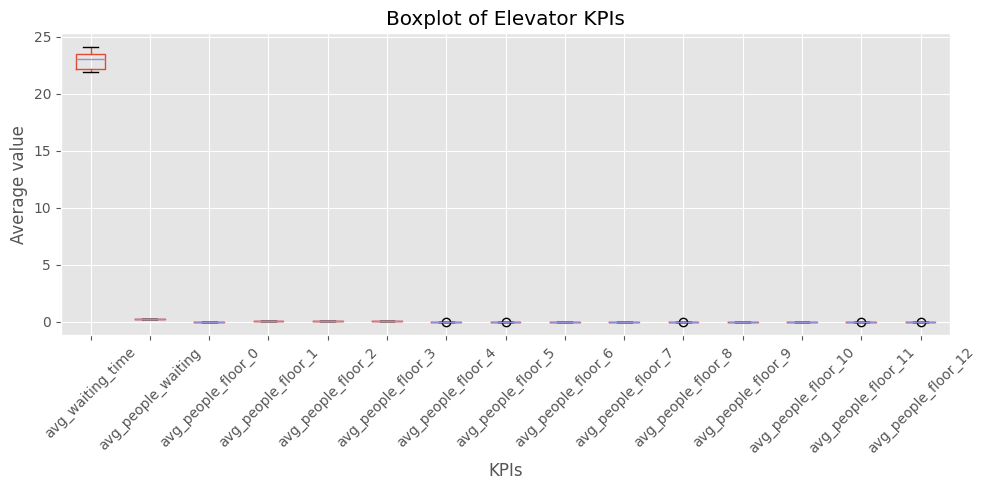

In [31]:
%matplotlib inline
import matplotlib.pyplot as plt


# Set the style
plt.style.use('ggplot')

ax = df_except_time_moving.boxplot()

ax.set_xlabel("KPIs")
ax.set_ylabel("Average value")
ax.figure.set_size_inches(10, 5)
ax.set_title("Boxplot of Elevator KPIs")

# Display the plot
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
plt.tight_layout()
plt.show()


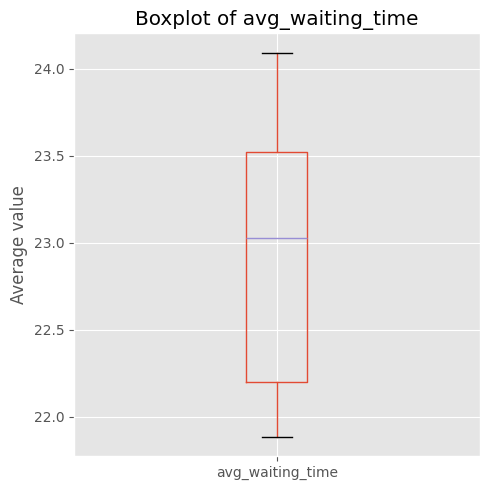

In [32]:
plt.style.use('ggplot')

# Plot the boxplot for 'avg_waiting_time'
plt.figure(figsize=(5, 5))
df[['avg_waiting_time']].boxplot()
plt.title("Boxplot of avg_waiting_time")
plt.ylabel("Average value")
plt.tight_layout()
plt.show()

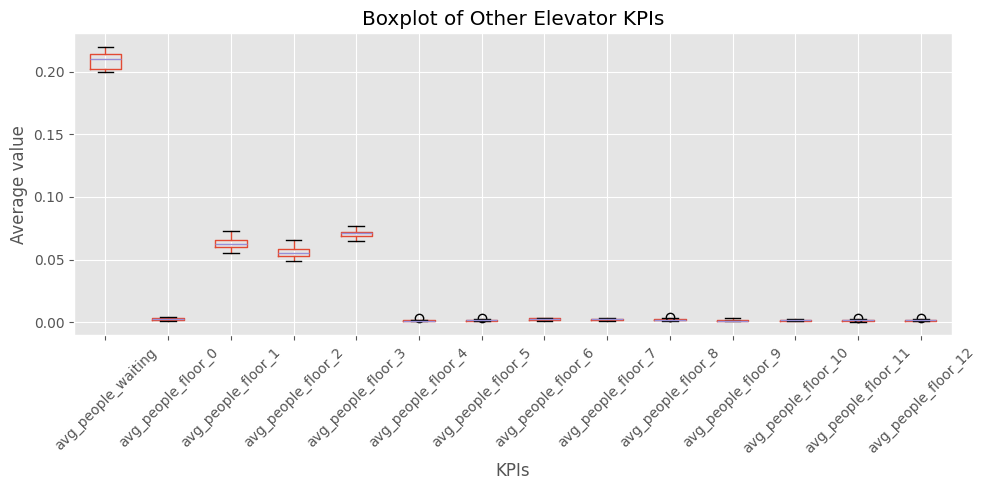

In [33]:
df_without_avg_waiting_time = df_except_time_moving.drop(columns=['avg_waiting_time'])

# Plot the boxplot for other KPIs
ax = df_without_avg_waiting_time.boxplot()
ax.set_xlabel("KPIs")
ax.set_ylabel("Average value")
ax.figure.set_size_inches(10, 5)
ax.set_title("Boxplot of Other Elevator KPIs")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

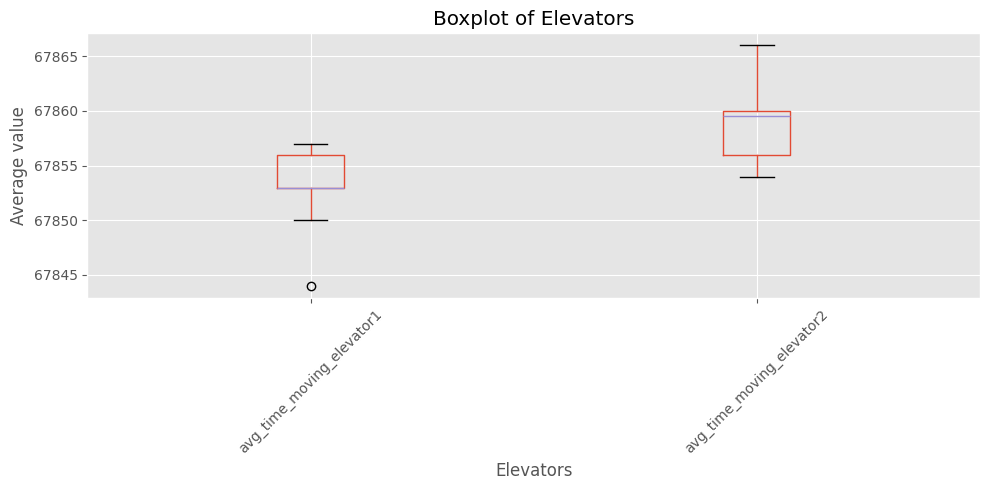

In [34]:
# Set the style
plt.style.use('ggplot')

ax = df_time_moving.boxplot()

ax.set_xlabel("Elevators")
ax.set_ylabel("Average value")
ax.figure.set_size_inches(10, 5)
ax.set_title("Boxplot of Elevators")

# Display the plot
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
plt.tight_layout()
plt.show()